In [1]:
import numpy as np
import matplotlib.pyplot as plt
from src.plotsiii import plotiii1, plotiii2
from src.plotsv import plotv1, plotv2

### Tensorflow HMC 

In [2]:
from corner import corner
import tensorflow as tf
import tensorflow_probability as tfp

tdf = tfp.distributions

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 16 from C header, got 96 from PyObject


In [3]:
# set seed
np.random.seed(120420)
tf.random.set_seed(120420)

# read text file
file_path = 'src/lighthouse_flash_data.txt'

# Read the data
def read_data(file_path):
    '''
    Function to read data from a text file and return it as two lists.
    '''
    # initialise lists to store the data
    column1 = []  
    column2 = []  
    
    with open(file_path, 'r') as file:  # Open the file for reading
        for line in file:  # Iterate over each line in the file
            parts = line.split()  # Split the line by whitespace
            
            # Append the parts to their respective column lists
            column1.append(float(parts[0]))
            column2.append(float(parts[1]))

    return column1, column2


In [4]:
# set seed
np.random.seed(120420)
tf.random.set_seed(120420)

# observed flashes
x_observed = np.array(read_data(file_path)[0], dtype=np.float32)

# constants for the uniform prior
a = -10
b = 10
c = 10

# joint log probability function
def joint_log_prob(x, alpha, beta):
    # likelihood
    likelihood = tdf.Cauchy(loc=alpha, scale=beta).log_prob(x)
    log_likelihood = tf.reduce_sum(likelihood)

    # prior
    log_prior_alpha = tf.where(
        tf.logical_and(alpha > a, alpha < b),
        tf.math.log(1/(b-a)),
        -np.inf
    
    )
    log_prior_beta = tf.where(
        tf.logical_and(beta > 0, beta < c),
        tf.math.log(1/c),
        -np.inf
    )

    return log_prior_alpha + log_prior_beta + log_likelihood

# Define the unnormalized posterior
def unnormalized_posterior(alpha, beta):
    return joint_log_prob(x_observed, alpha, beta)


In [5]:
# hmc kernel
hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
  target_log_prob_fn=unnormalized_posterior,
  step_size=np.float64(.01),
  num_leapfrog_steps=200) # 200

'''# Adpative step size
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
  hmc_kernel,
  num_adaptation_steps=int())
'''
# run hmc
@tf.function
def run_chain(num_results=30000, num_burnin_steps=3000):
  samples, kernel_results = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=[np.mean(x_observed), 1.0],
      kernel=hmc_kernel,
      trace_fn=lambda _, pkr: pkr.is_accepted
      )
  return samples, kernel_results

samples, kernel_results = run_chain()
alpha_samples, beta_samples = samples

/Users/maxtalberg/miniconda3/envs/S2-env/lib/python3.8/site-packages/tensorflow_probability/python/__init__.py:74: UserWarning: TensorFloat-32 matmul/conv are enabled for NVIDIA Ampere+ GPUs. The resulting loss of precision may hinder MCMC convergence. To turn off, run `tf.config.experimental.enable_tensor_float_32_execution(False)`. For more detail, see https://github.com/tensorflow/community/pull/287.
  warnings.warn(
2024-03-07 21:24:21.817624: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [6]:
# mean and std of alpha and beta
mean_alpha = np.mean(alpha_samples)
std_alpha = np.std(alpha_samples)

mean_beta = np.mean(beta_samples)
std_beta = np.std(beta_samples)

print('alpha:', mean_alpha, std_alpha)
print('beta:', mean_beta, std_beta)

alpha: -0.4486366 0.6110102
beta: 1.9690804 0.6654105


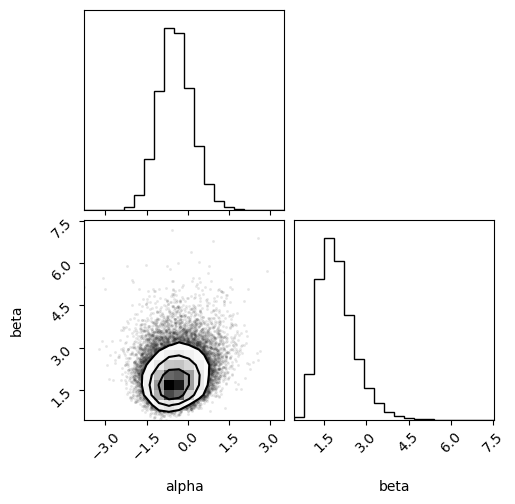

In [7]:
samples_np = np.column_stack([tensor.numpy() for tensor in samples])
corner(samples_np, labels=['alpha', 'beta'])
plt.show()

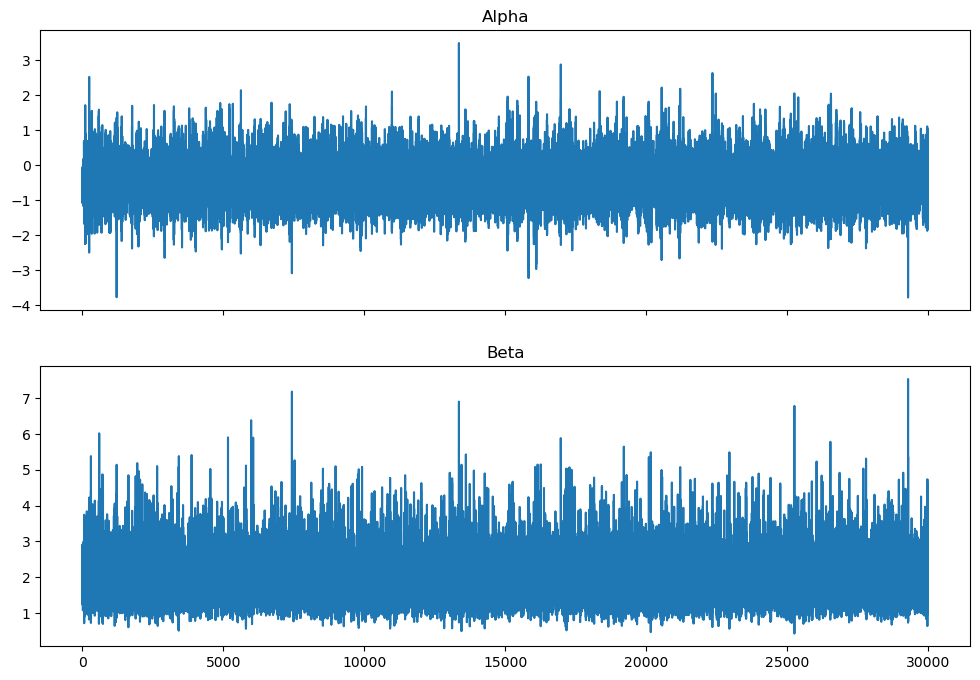

In [8]:
# plot alpha and beta samples
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
axes[0].plot(alpha_samples)
axes[0].title.set_text('Alpha')
axes[1].plot(beta_samples)
axes[1].title.set_text('Beta')
plt.show()


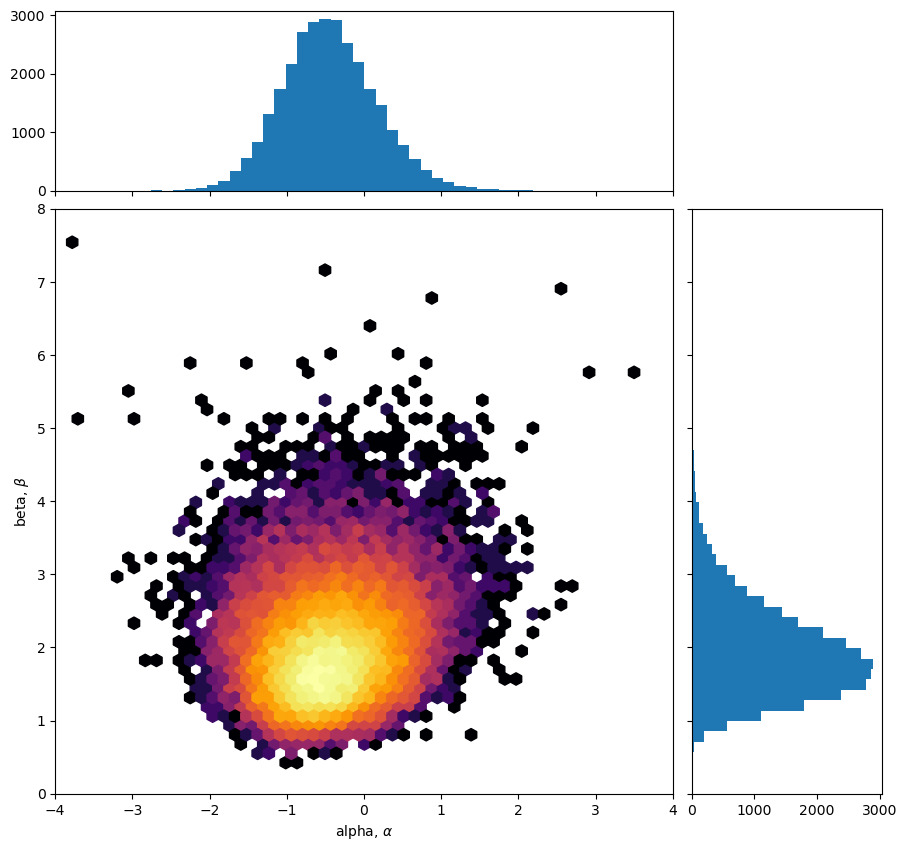

In [9]:
plotv1(samples)

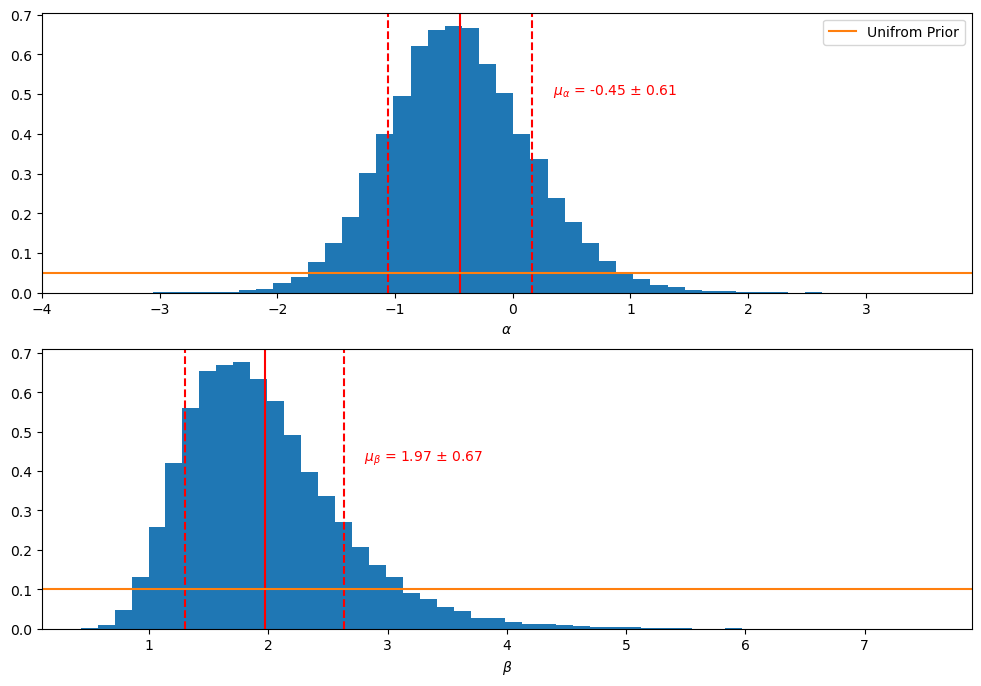

In [10]:
plotv2(samples)

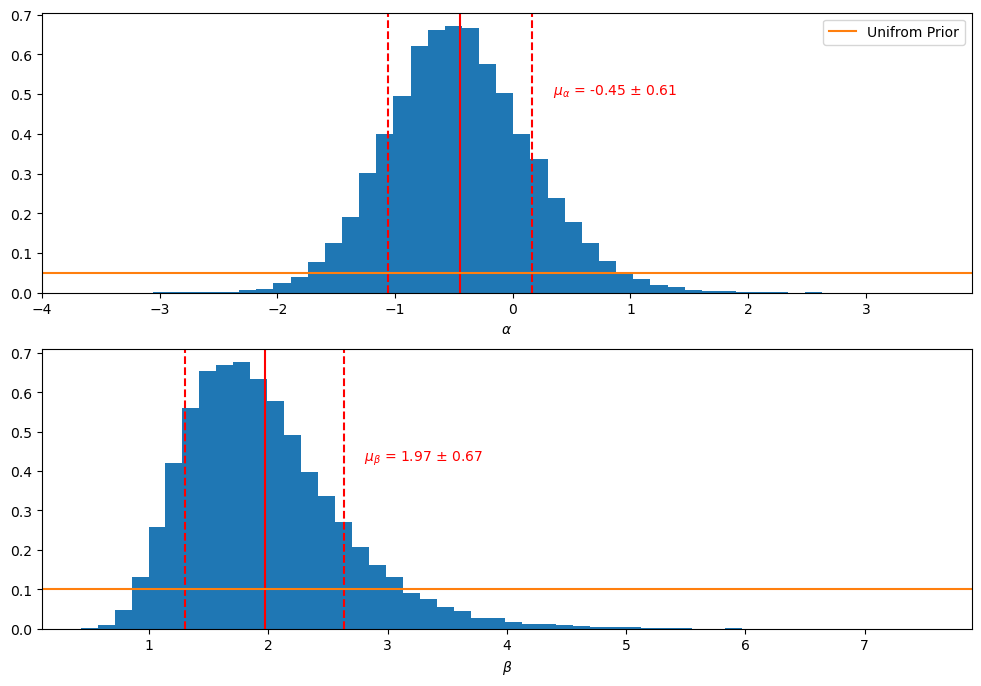

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

tdf = tfp.distributions

# Assuming alpha_samples and beta_samples are defined and contain your MCMC samples
alpha_samples = samples[0]
beta_samples = samples[1]

# Calculate mean, median, and standard deviation
mean_alpha = np.mean(alpha_samples)
median_alpha = np.median(alpha_samples)
std_alpha = np.std(alpha_samples)

mean_beta = np.mean(beta_samples)
median_beta = np.median(beta_samples)
std_beta = np.std(beta_samples)

# Create histograms for alpha and beta
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot for alpha
axes[0].hist(alpha_samples, bins=50, density=True)
axes[0].axvline(mean_alpha, color='r', linestyle='-')
axes[0].axvline(mean_alpha + std_alpha, color='r', linestyle='--')
axes[0].axvline(mean_alpha - std_alpha, color='r', linestyle='--')
axes[0].set_xlim([-4, 3.9])
axes[0].set_xlabel(r'$\alpha$')
axes[0].text(mean_alpha+2*std_alpha+0.1, plt.ylim()[1] * 0.5, fr'$\mu_\alpha$ = {mean_alpha:.2f} $\pm$ {std_alpha:.2f}', horizontalalignment='center', color='r')


# Plot prior for alpha
x_alpha = np.linspace(-10, 10, 100)
y_alpha = tdf.Uniform(-10, 10).prob(x_alpha).numpy()  # Convert to NumPy array for Matplotlib
axes[0].plot(x_alpha, y_alpha, label='Unifrom Prior')
axes[0].legend()

# Plot for beta
axes[1].hist(beta_samples, bins=50, density=True)
axes[1].axvline(mean_beta, color='r', linestyle='-')
axes[1].axvline(mean_beta + std_beta, color='r', linestyle='--')
axes[1].axvline(mean_beta - std_beta, color='r', linestyle='--')
axes[1].set_xlim([0.1, 7.9])
axes[1].set_xlabel(r'$\beta$')
axes[1].text(mean_beta+2*std_beta, plt.ylim()[1] * 0.6, fr'$\mu_\beta$ = {mean_beta:.2f} $\pm$ {std_beta:.2f}', horizontalalignment='center', color='r')


# Plot prior for beta
x_beta = np.linspace(0, 10, 100)
y_beta = tdf.Uniform(0, 10).prob(x_beta).numpy()  # Convert to NumPy array for Matplotlib
axes[1].plot(x_beta, y_beta, label='Uniform Prior')


plt.show()
